In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pickle
import tqdm as tqdm
import pandas as pd
import copy
import torch.nn as nn
import shap

import sys
sys.path.insert(1, '../../models/Multi-Body')
from multidataset import MultiDataset
from multimodel import Net as Model

In [417]:
#Parameters to change, can change model_type to 'best' or 'last'
use_jet_pt = True
use_jet_mass = True
N = 6
model_type = 'best'
extra_name = ''
#Testing path
test_path = '../../datasets/n-subjettiness_data/test_all.npy'

#model path
model_path = '../../models/Multi-Body/models/MultiBody' + str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+'_'+ model_type + extra_name

#Loading testing dataset
test_set = MultiDataset(test_path, N, use_jet_pt, use_jet_mass)

#loading model
model = Model(N, use_jet_pt, use_jet_mass).double()
model.load_state_dict(torch.load(model_path))
model.eval()

Net(
  (dense1): Linear(in_features=16, out_features=200, bias=True)
  (dense2): Linear(in_features=200, out_features=200, bias=True)
  (dense3): Linear(in_features=200, out_features=50, bias=True)
  (dense4): Linear(in_features=50, out_features=50, bias=True)
  (dense5): Linear(in_features=50, out_features=2, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (softmax): Softmax(dim=1)
)

In [418]:
#LRP options
zero_bias = False #Zeros bias
abs_relevance_score = True #Takes absolute value of relevances
epsilon = 1e-9
gamma = 1
#Can use LRP-gamma, LRP-epsilon, or LRP-zero, and it would be 'gamma' 'epsilon' or 'zero'
lrp_type = 'gamma'
options = ''
if zero_bias:
    options += '_zero_bias'
if abs_relevance_score:
    options += '_abs'
if lrp_type == 'gamma':
    options += '_LRP-' + lrp_type + '_' + str(gamma)
elif lrp_type == 'epsilon':
    options += '_LRP-' + lrp_type + '_' + str(epsilon)
elif lrp_type == 'zero':
    options += '_LRP-' + lrp_type

In [419]:
classes = []
for i in range(N-1):
    if i != N-2:
        classes.append('tau_'+str(i+1)+'_'+str(0.5))
        classes.append('tau_'+str(i+1)+'_'+str(1))
        classes.append('tau_'+str(i+1)+'_'+str(2))
    else:
        classes.append('tau_'+str(i+1)+'_'+str(1))
        classes.append('tau_'+str(i+1)+'_'+str(2))
if use_jet_pt:
    classes.append('jet_pt')
if use_jet_mass:
    classes.append('jet_mass')

In [420]:
layer_names = ['dense1', 'relu', 'dropout2', 'dense2', 'relu', 'dropout2', 'dense3', 'relu', 
              'dropout1', 'dense4', 'relu', 'dropout1', 'dense5', 'softmax']
data,labels = test_set[:]
full_data = np.concatenate((data,labels),axis=1)
df_test = pd.DataFrame(full_data, columns=np.append(classes, ['background_prob', 'signal_prob']))
sig = df_test.loc[df_test['signal_prob'] == 1].drop(columns=['background_prob', 'signal_prob']).to_numpy()
L=14
A = [torch.from_numpy(sig)]+[None]*L
for i in range(L):
    A[i+1] = model._modules[layer_names[i]].forward(A[i])
print('done')

done


In [421]:
def newlayer(layer,g):

    layer = copy.deepcopy(layer)
    with torch.no_grad():
        try: layer.weight = nn.Parameter(g(layer.weight))
        except AttributeError: pass
        
        if zero_bias:
            try: nn.init.constant_(layer.bias, 0.0)
            except AttributeError: pass
        else:
            try: layer.bias   = nn.Parameter(g(layer.bias))
            except AttributeError: pass

    return layer

In [422]:
#Copying model
model_copy = Model(N, use_jet_pt, use_jet_mass).double()
model_copy.load_state_dict(torch.load(model_path))
model_copy.eval()

Net(
  (dense1): Linear(in_features=16, out_features=200, bias=True)
  (dense2): Linear(in_features=200, out_features=200, bias=True)
  (dense3): Linear(in_features=200, out_features=50, bias=True)
  (dense4): Linear(in_features=50, out_features=50, bias=True)
  (dense5): Linear(in_features=50, out_features=2, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (softmax): Softmax(dim=1)
)

In [423]:
#Combine Dense+Activation functions
#A[13] uses pre-sigmoid output, A[14] uses sigmoid output. Change the else statement as well
B = [A[0], A[3], A[6], A[9], A[12], A[13][:,1][...,None]]
# Backpropagate relevance scores
if lrp_type == 'zero':
    rho = lambda p: p;                       incr = lambda z: z
elif lrp_type == 'gamma':
    rho = lambda p: p + gamma*p.clamp(min=0); incr = lambda z: z
elif lrp_type == 'epsilon':
    rho = lambda p: p;                       incr = lambda z: z+epsilon
R = [None]*5 + [B[-1]]
# Iterate over the layers in reverse order
for l in range(0,5)[::-1]:    
    B[l] = (B[l].data).requires_grad_(True)
    
    z = newlayer(model_copy._modules[layer_names[3*l]], rho).forward(B[l]) # setp 1
    if l != 4:
        z = model_copy._modules[layer_names[3*l+1]].forward(z)
        z = incr(model_copy._modules[layer_names[3*l+2]].forward(z))
    else:
        z = incr(z[:,1][...,None])
        
    inds_nz = z != 0
    R1_sum = sum(R[l+1].clone())
    R2_sum_nz = sum(R[l+1][inds_nz].clone())
    R[l+1] = R[l+1].clone()*R1_sum/R2_sum_nz
    z = torch.where(z == torch.DoubleTensor([0]), torch.DoubleTensor([1]), z)
    R[l + 1] = torch.where(z == torch.DoubleTensor([0]), torch.DoubleTensor([0]), R[l+1])
    
    s = (R[l+1]/z).data                                    # step 2
    (z*s).sum().backward(); c = B[l].grad                  # step 3
    R[l] = (B[l]*c).data                                   # step 4

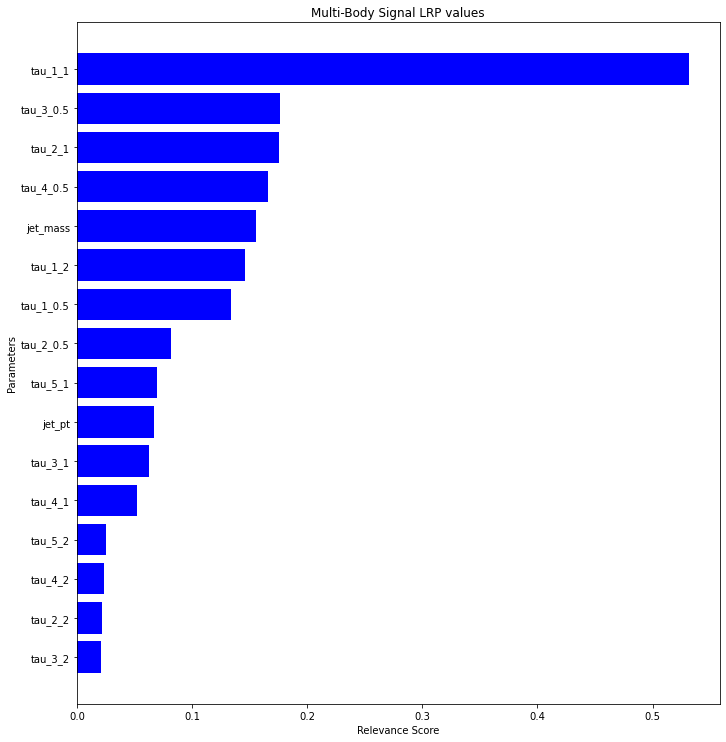

In [424]:
#Plots relevances as normalized and take absolute value
normal_rel = np.empty_like(R[0])
#Normalizes relevances for each sample
normal_rel = R[0]/np.sum(R[0].detach().numpy(), 1)[:, np.newaxis]
maximum = np.sort(np.abs(normal_rel.flatten()))[-5000]
normal_rel = np.where(np.abs(normal_rel) < maximum, normal_rel, 0)
if abs_relevance_score: #Takes absolute value of relevance score if wanted
    normal_rel = np.abs(normal_rel)
relevances = np.nanmean(normal_rel, 0) #Takes mean across all jets
df_sig_rel = pd.DataFrame(dict(params=classes, rels=relevances))
df_sig_rel_sorted = df_sig_rel.sort_values('rels') #Sorts relevance values
fig = plt.figure(figsize = (10, 10))
# creating the bar plot
max_display = 20
plt.barh('params', 'rels', data = df_sig_rel_sorted.tail(max_display), color ='blue')
plt.tight_layout()
plt.xlabel("Relevance Score")
plt.ylabel("Parameters")
plt.title("Multi-Body Signal LRP values")
#Saves plot
plt.savefig("figures/"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+"/LRP_sig"+options+".png", dpi = 150, bbox_inches='tight')
plt.show()

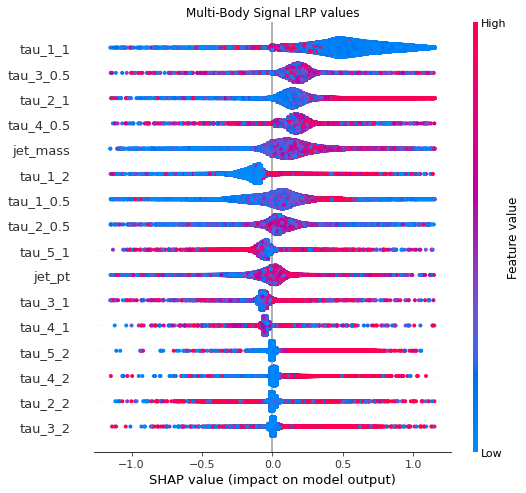

In [425]:
a = R[0]/np.sum(R[0].detach().numpy(), 1)[:, np.newaxis]
#maximum = np.sort(np.abs(a.flatten()))[-220028]
maximum = np.sort(np.abs(a.flatten()))[-5000]

scores = np.where(np.abs(a) < maximum, a, 0)
shap.summary_plot(scores, sig, feature_names=classes, max_display = 20, plot_type = "dot", show=False)
plt.title('Multi-Body Signal LRP values')
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)
plt.savefig("figures/"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+"/LRP_sig"+options.replace('_abs', '')+"_dist.png", dpi = 150, bbox_inches='tight')
plt.show()

In [202]:
#Copying model
model_copy = Model(N, use_jet_pt, use_jet_mass).double()
model_copy.load_state_dict(torch.load(model_path))
model_copy.eval()

#Combine Dense+Activation functions
#A[13] uses pre-sigmoid output, A[14] uses sigmoid output. Change the else statement as well
B = [A[0], A[3], A[6], A[9], A[12], A[13][:,0][...,None]]
# Backpropagate relevance scores
if lrp_type == 'zero':
    rho = lambda p: p;                       incr = lambda z: z
elif lrp_type == 'gamma':
    rho = lambda p: p + gamma*p.clamp(min=0); incr = lambda z: z
elif lrp_type == 'epsilon':
    rho = lambda p: p;                       incr = lambda z: z+epsilon
R1 = [None]*5 + [B[-1]]
# Iterate over the layers in reverse order
for l in range(0,5)[::-1]:    
    B[l] = (B[l].data).requires_grad_(True)
    
    z = newlayer(model_copy._modules[layer_names[3*l]], rho).forward(B[l]) # setp 1
    if l != 4:
        z = model_copy._modules[layer_names[3*l+1]].forward(z)
        z = incr(model_copy._modules[layer_names[3*l+2]].forward(z))
    else:
        z = incr(z[:,0][...,None])
        
    inds_nz = z != 0
    R1_sum = sum(R1[l+1].clone())
    R2_sum_nz = sum(R1[l+1][inds_nz].clone())
    R1[l+1] = R1[l+1].clone()*R1_sum/R2_sum_nz
    z = torch.where(z == torch.DoubleTensor([0]), torch.DoubleTensor([1]), z)
    R1[l + 1] = torch.where(z == torch.DoubleTensor([0]), torch.DoubleTensor([0]), R1[l+1])
    
    s = (R1[l+1]/z).data                                    # step 2
    (z*s).sum().backward(); c = B[l].grad                  # step 3
    R1[l] = (B[l]*c).data                                   # step 4

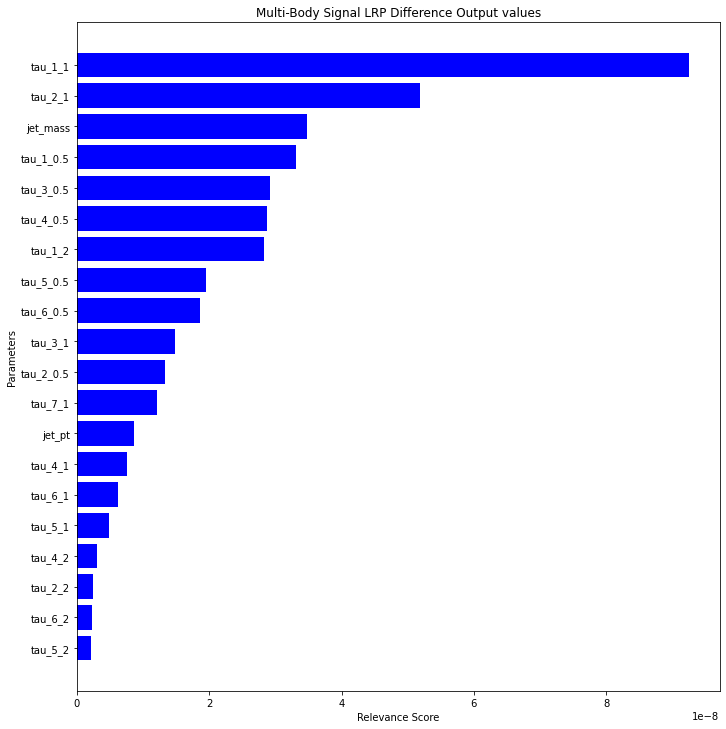

In [203]:
#Plots differences in LRP scores and take absolute value
normal_rel = np.empty_like(R[0])
#Normalizes relevances for each sample
normal_rel = (R[0]-R1[0])/(A[13][:,1][...,None]-A[13][:,0][...,None])
normal_rel = normal_rel.detach().numpy()
maximum = np.sort(np.abs(normal_rel.flatten()))[-5000]
normal_rel = np.where(np.abs(normal_rel) < maximum, normal_rel, 0)
if abs_relevance_score: #Takes absolute value of relevance score if wanted
    normal_rel = np.abs(normal_rel)
relevances = np.nanmean(normal_rel, 0) #Takes mean across all jets
df_sig_rel = pd.DataFrame(dict(params=classes, rels=relevances))
df_sig_rel_sorted = df_sig_rel.sort_values('rels') #Sorts relevance values
fig = plt.figure(figsize = (10, 10))
# creating the bar plot
max_display = 20
plt.barh('params', 'rels', data = df_sig_rel_sorted.tail(max_display), color ='blue')
plt.tight_layout()
plt.xlabel("Relevance Score")
plt.ylabel("Parameters")
plt.title("Multi-Body Signal LRP Difference Output values")
#Saves plot
#plt.savefig("figures/"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+"/diff_LRP_sig"+options+".png", dpi = 150, bbox_inches='tight')
plt.show()

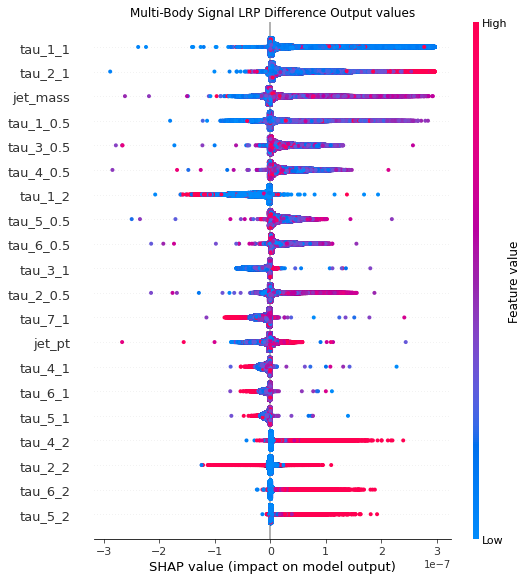

In [204]:
a = ((R[0]-R1[0])/(A[13][:,1][...,None]-A[13][:,0][...,None])).detach().numpy()
#maximum = np.sort(np.abs(a.flatten()))[-220028]
maximum = np.sort(np.abs(a.flatten()))[-5000]

scores = np.where(np.abs(a) < maximum, a, 0)
shap.summary_plot(scores, sig, feature_names=classes, max_display = 20, plot_type = "dot", show=False)
plt.title('Multi-Body Signal LRP Difference Output values')
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)
#plt.savefig("figures/"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+"/diff_LRP_sig"+options.replace('_abs', '')+"_dist.png", dpi = 150, bbox_inches='tight')
plt.show()

In [426]:
bkg = df_test.loc[df_test['background_prob'] == 1].drop(columns=['background_prob', 'signal_prob']).to_numpy()
L=14
A_ = [torch.from_numpy(bkg)]+[None]*L
for i in range(L):
    A_[i+1] = model._modules[layer_names[i]].forward(A_[i])

#Copying model
model_copy = Model(N, use_jet_pt, use_jet_mass).double()
model_copy.load_state_dict(torch.load(model_path))
model_copy.eval()

Net(
  (dense1): Linear(in_features=16, out_features=200, bias=True)
  (dense2): Linear(in_features=200, out_features=200, bias=True)
  (dense3): Linear(in_features=200, out_features=50, bias=True)
  (dense4): Linear(in_features=50, out_features=50, bias=True)
  (dense5): Linear(in_features=50, out_features=2, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (softmax): Softmax(dim=1)
)

In [427]:
#Combine Dense+Activation functions
#A[13] uses pre-sigmoid output, A[14] uses sigmoid output. Change the else statement as well
B = [A_[0], A_[3], A_[6], A_[9], A_[12], A_[13][:,0][...,None]]
# Backpropagate relevance scores
if lrp_type == 'zero':
    rho = lambda p: p;                       incr = lambda z: z
elif lrp_type == 'gamma':
    rho = lambda p: p + gamma*p.clamp(min=0); incr = lambda z: z
elif lrp_type == 'epsilon':
    rho = lambda p: p;                       incr = lambda z: z+epsilon
R_ = [None]*5 + [B[-1]]
# Iterate over the layers in reverse order
for l in range(0,5)[::-1]:    
    B[l] = (B[l].data).requires_grad_(True)
    
    z = newlayer(model_copy._modules[layer_names[3*l]], rho).forward(B[l]) # setp 1
    if l != 4:
        z = model_copy._modules[layer_names[3*l+1]].forward(z)
        z = incr(model_copy._modules[layer_names[3*l+2]].forward(z))
    else:
        z = incr(z[:,0][...,None])
        
    inds_nz = z != 0
    R1_sum = sum(R_[l+1].clone())
    R2_sum_nz = sum(R_[l+1][inds_nz].clone())
    R_[l+1] = R_[l+1].clone()*R1_sum/R2_sum_nz
    z = torch.where(z == torch.DoubleTensor([0]), torch.DoubleTensor([1]), z)
    R_[l + 1] = torch.where(z == torch.DoubleTensor([0]), torch.DoubleTensor([0]), R_[l+1])

    s = (R_[l+1]/z).data                                    # step 2
    (z*s).sum().backward(); c = B[l].grad                  # step 3
    R_[l] = (B[l]*c).data                                   # step 4

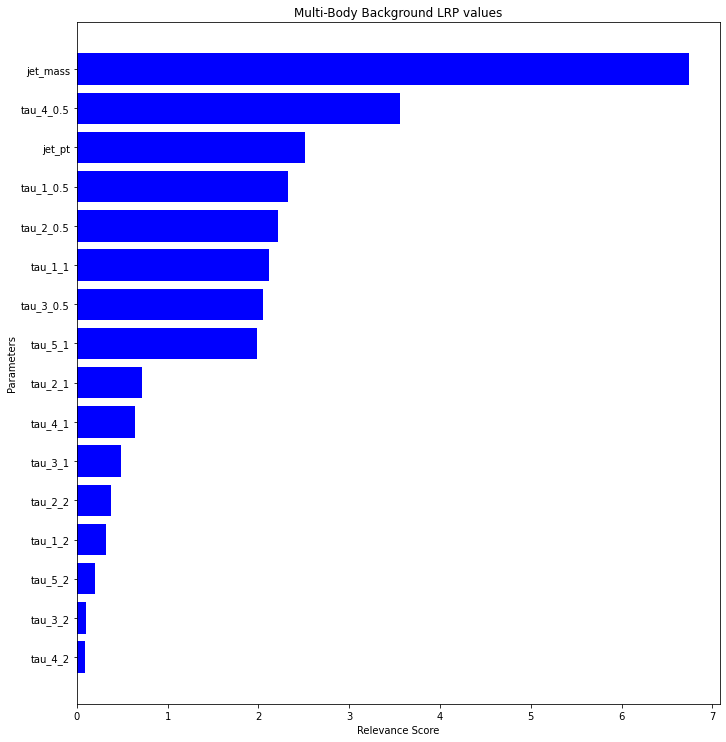

In [428]:
#Plots relevances as normalized and take absolute value
normal_rel = np.empty_like(R_[0])
#Normalizes relevances for each sample
normal_rel = R_[0]/np.sum(R_[0].detach().numpy(), 1)[:, np.newaxis]
maximum = np.sort(np.abs(normal_rel.flatten()))[-5000]
normal_rel = np.where(np.abs(normal_rel) < maximum, normal_rel, 0)
if abs_relevance_score: #Takes absolute value of relevance score if wanted
    normal_rel = np.abs(normal_rel)
relevances = np.nanmean(normal_rel, 0) #Takes mean across all jets
df_sig_rel = pd.DataFrame(dict(params=classes, rels=relevances))
df_sig_rel_sorted = df_sig_rel.sort_values('rels') #Sorts relevance values
fig = plt.figure(figsize = (10, 10))
# creating the bar plot
max_display = 20
plt.barh('params', 'rels', data = df_sig_rel_sorted.tail(max_display), color ='blue')
plt.tight_layout()
plt.xlabel("Relevance Score")
plt.ylabel("Parameters")
plt.title("Multi-Body Background LRP values")
#Saves plot
plt.savefig("figures/"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+"/LRP_bkg"+options+".png", dpi = 150, bbox_inches='tight')
plt.show()

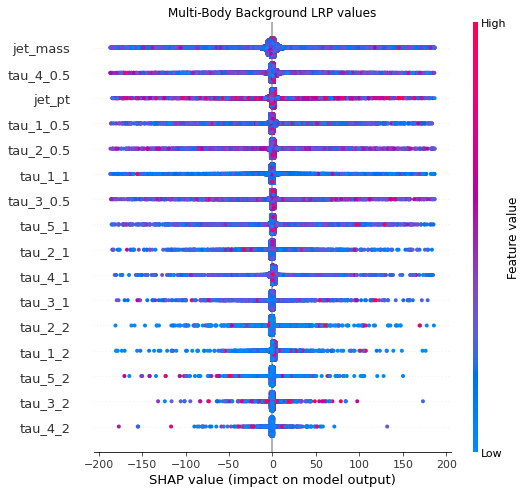

In [429]:
a = R_[0]/np.sum(R_[0].detach().numpy(), 1)[:, np.newaxis]
#maximum = np.sort(np.abs(a.flatten()))[-220028]
maximum = np.sort(np.abs(a.flatten()))[-5000]

scores = np.where(np.abs(a) < maximum, a, 0)
shap.summary_plot(scores, bkg, feature_names=classes, max_display = 20, plot_type = "dot", show=False)
plt.title('Multi-Body Background LRP values')
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)
plt.savefig("figures/"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+"/LRP_bkg"+options.replace('_abs', '')+"_dist.png", dpi = 150, bbox_inches='tight')
plt.show()

In [209]:
#Copying model
model_copy = Model(N, use_jet_pt, use_jet_mass).double()
model_copy.load_state_dict(torch.load(model_path))
model_copy.eval()

#Combine Dense+Activation functions
#A[13] uses pre-sigmoid output, A[14] uses sigmoid output. Change the else statement as well
B = [A_[0], A_[3], A_[6], A_[9], A_[12], A_[13][:,1][...,None]]
# Backpropagate relevance scores 
if lrp_type == 'zero':
    rho = lambda p: p;                       incr = lambda z: z
elif lrp_type == 'gamma':
    rho = lambda p: p + gamma*p.clamp(min=0); incr = lambda z: z
elif lrp_type == 'epsilon':
    rho = lambda p: p;                       incr = lambda z: z+epsilon
R_1 = [None]*5 + [B[-1]]
# Iterate over the layers in reverse order
for l in range(0,5)[::-1]:    
    B[l] = (B[l].data).requires_grad_(True)
    
    z = newlayer(model_copy._modules[layer_names[3*l]], rho).forward(B[l]) # setp 1
    if l != 4:
        z = model_copy._modules[layer_names[3*l+1]].forward(z)
        z = incr(model_copy._modules[layer_names[3*l+2]].forward(z))
    else:
        z = incr(z[:,1][...,None])
        
    inds_nz = z != 0
    R1_sum = sum(R_1[l+1].clone())
    R2_sum_nz = sum(R_1[l+1][inds_nz].clone())
    R_1[l+1] = R_1[l+1].clone()*R1_sum/R2_sum_nz
    z = torch.where(z == torch.DoubleTensor([0]), torch.DoubleTensor([1]), z)
    R_1[l + 1] = torch.where(z == torch.DoubleTensor([0]), torch.DoubleTensor([0]), R_1[l+1])

    s = (R_1[l+1]/z).data                                    # step 2
    (z*s).sum().backward(); c = B[l].grad                  # step 3
    R_1[l] = (B[l]*c).data                                   # step 4

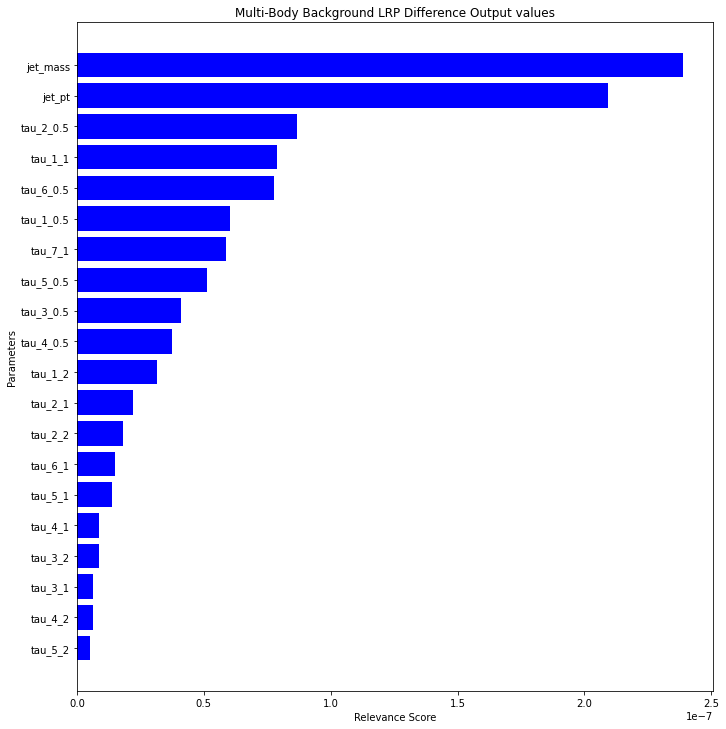

In [210]:
#Plots differences in LRP scores and take absolute value
normal_rel = np.empty_like(R_[0])
#Normalizes relevances for each sample
normal_rel = (R_[0]-R_1[0])/(A_[13][:,0][...,None]-A_[13][:,1][...,None])
normal_rel = normal_rel.detach().numpy()
maximum = np.sort(np.abs(normal_rel.flatten()))[-5000]
normal_rel = np.where(np.abs(normal_rel) < maximum, normal_rel, 0)
if abs_relevance_score: #Takes absolute value of relevance score if wanted
    normal_rel = np.abs(normal_rel)
relevances = np.nanmean(normal_rel, 0) #Takes mean across all jets
df_sig_rel = pd.DataFrame(dict(params=classes, rels=relevances))
df_sig_rel_sorted = df_sig_rel.sort_values('rels') #Sorts relevance values
fig = plt.figure(figsize = (10, 10))
# creating the bar plot
max_display = 20
plt.barh('params', 'rels', data = df_sig_rel_sorted.tail(max_display), color ='blue')
plt.tight_layout()
plt.xlabel("Relevance Score")
plt.ylabel("Parameters")
plt.title("Multi-Body Background LRP Difference Output values")
#Saves plot
#plt.savefig("figures/"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+"/diff_LRP_bkg"+options+".png", dpi = 150, bbox_inches='tight')
plt.show()

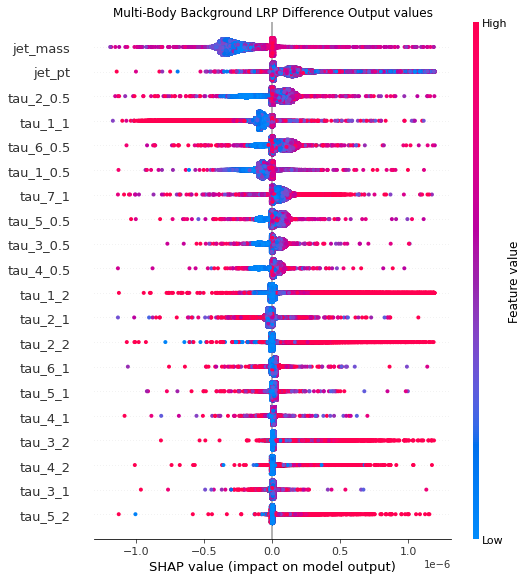

In [211]:
a = ((R_[0]-R_1[0])/(A_[13][:,0][...,None]-A_[13][:,1][...,None])).detach().numpy()
#maximum = np.sort(np.abs(a.flatten()))[-220028]
maximum = np.sort(np.abs(a.flatten()))[-5000]

scores = np.where(np.abs(a) < maximum, a, 0)
shap.summary_plot(scores, bkg, feature_names=classes, max_display = 20, plot_type = "dot", show=False)
plt.title('Multi-Body Background LRP Difference Output values')
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)
#plt.savefig("figures/"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+"/diff_LRP_bkg"+options.replace('_abs', '')+"_dist.png", dpi = 150, bbox_inches='tight')
plt.show()